# 02. PyTorch Neural Network Classification

### What is a classification problem?
A classification problem involves predicting whether something is one thing or another.

For example:
| **Problem type** | **What is it?** | **Example** |
| --- | --- | --- |
| **Binary classification** | Target can be one of two options, e.g. yes or no | Predict whether or not someone has heart disease based on their health parameters. |
| **Multi-class classification** | Target can be one of more than two options | Decide whether a photo of is of food, a person or a dog. |
| **Multi-label classification** | Target can be assigned more than one option | Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosophy). |

![Image](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-different-classification-problems.png)

### Course topic and contents

![Image](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png)

We'll be working on a **classification problem**
| Topic | Contents |
| --- | --- |
| 0. Architecture of a classification neural network | Neural networks can come in almost any shape or size, but they typically follow a similar floor plan. |
| 1. Getting binary classification data ready | Data can be almost anything but to get started we're going to create a simple binary classification dataset. |
| 2. Building a PyTorch classification model | Here we'll create a model to learn patterns in the data, we'll also choose a loss function, optimizer and build a training loop specific to classification. |
| 3. Fitting the model to data (training) | We've got data and a model, now let's let the model (try to) find patterns in the (training) data. |
| 4. Making predictions and evaluating a model (inference) | Our model's found patterns in the data, let's compare its findings to the actual (testing) data. |
| 5. Improving a model (from a model perspective) | We've trained and evaluated a model but it's not working, let's try a few things to improve it. |
| 6. Non-linearity | So far our model has only had the ability to model straight lines, what about non-linear (non-straight) lines? |
| 7. Replicating non-linear functions | We used non-linear functions to help model non-linear data, but what do these look like? |
| 8. Putting it all together with multi-class classification | Let's put everything we've done so far for binary classification together with a multi-class classification problem. |


## 0. Architecture of a classification neural network

General architecture of a classification neural network.
| Hyperparameter | Binary Classification | Multiclass classification |
| --- | --- | --- |
| Input layer shape (in_features) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 512 | Same as binary classification |
| Output layer shape (out_features) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden layer activation | Usually `ReLU` (rectified linear unit) but can be many others | Same as binary classification |
| Output activation | `Sigmoid` (`torch.sigmoid` in PyTorch) | `Softmax` (`torch.softmax` in PyTorch) |
| Loss function | Binary crossentropy (`torch.nn.BCELoss` in PyTorch) | Cross entropy (`torch.nn.CrossEntropyLoss` in PyTorch) |
| Optimizer | `SGD` (stochastic gradient descent), `Adam` (see `torch.optim` for more options) | Same as binary classification |


## 1. Make classification data and get it ready

We'll use the [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) method from Scikit-Learn to generate two circles with different coloured dots.

In [3]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y =make_circles(n_samples=n_samples,
                   noise=0.03, # a little bit of noise to the dots
                   random_state=42) # keep random state so we get the same values

In [4]:
# View the first 5 x and y values.
print(f"First 5 X feature:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X feature:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


Looks like there's two `X` values per one `y` value.

data explorer's motto of *visualize*, *visualize*, *visualize* 

In [7]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


It looks like each pair of `X` features (`X1` and `X2`) has a label (`y`) value of either 0 or 1.

This tells us that our problem is **binary classification** since there's only two options (0 or 1).

In [8]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

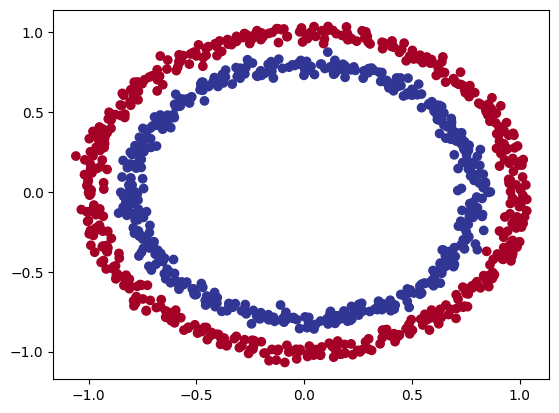

In [9]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

Let's find out how we could build a PyTorch neural network to classify dots into red (0) or blue (1).

>Note: This dataset is often what's considered a toy problem (a problem that's used to try and test things out on) in machine learning.

>But it represents the major key of classification, you have some kind of data represented as numerical values and you'd like to build a model that's able to classify it, in our case, separate it into red or blue dots.

### 1.1 Input and shapes

In [10]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [11]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


`X` has two features (vector) where as `y` has a single feature (scalar).

### 1.2 Turn data into tensors and create train and test splits

1. Turn our data into tensors (right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors).
2. Split our data into training and test sets (we'll train a model on the training set to learn the patterns between X and y and then evaluate those learned patterns on the test dataset).

In [12]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

We'll use `test_size=0.2` (80% training, 20% testing) and because the split happens randomly across the data, let's use `random_state=42` so the split is reproducible.

In [14]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Break in down into few parts.
1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing `nn.Module`.
3. Defining a loss function and optimizer.
4. Creating a training loop (this'll be in the next section).

In [15]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

We'll want a model capable of handling our `X` data as inputs and producing something in the shape of our `y` data as outputs.

In other words, given `X` (features) we want our model to predict `y` (label).

This setup where you have features and labels is referred to as **supervised learning**. Because your data is telling your model what the outputs should be given a certain input.

Let's create a model class that:

1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of `nn.Module`).
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of `X` and `y`.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target `device`.

In [16]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features (X), produces 1 features
        
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0  = CircleModelV0().to(device=device)
model_0      

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

* The function self.layer_1 takes 2 input features (in_features=2) and produces 5 output features (out_features=5), known as hidden units or neurons. This allows the model to learn patterns from 5 numbers rather than just 2, potentially improving its outputs.
* The number of hidden units in neural network layers is a hyperparameter, a value you can set yourself. While generally more hidden units are better, too many can be detrimental. The optimal number will depend on your model type and dataset.
* For our small and simple dataset, a small number of hidden units is sufficient.
* The key rule with hidden units is that the next layer must take the same number of in_features as the previous layer's out_features.
* Thus, self.layer_2 has in_features=5, taking the out_features=5 from self.layer_1 and performing a linear computation on them, turning them into out_features=1 (the same shape as y).

In [17]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)


That looks much simpler than subclassing `nn.Module`, why not just always use `nn.Sequential`?

`nn.Sequential` is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

So if you'd something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom `nn.Module` subclass.

In [18]:
# Make prediction with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.2188],
        [0.2112],
        [0.3379],
        [0.1847],
        [0.4951],
        [0.4892],
        [0.3431],
        [0.4086],
        [0.3311],
        [0.2124]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


it seems there's the same amount of predictions as there is test labels but the predictions don't look like they're in the same form or shape as the test labels.

We've got a couple steps we can do to fix this, we'll see these later on.

### 2.1 Setup loss function and optimizer

We've setup a loss (also called a criterion or cost function) and optimizer before in notebook 01.

But different problem types require different loss functions.

For example, for a regression problem (predicting a number) you might used mean absolute error (MAE) loss.

And for a binary classification problem (like ours), you'll often use [binary cross entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) as the loss function.

However, the same optimizer function can often be used across different problem spaces.

**For example**, the *stochastic gradient descent optimizer* (SGD, `torch.optim.SGD()`) can be used for a range of problems, so can too the *Adam optimizer* (`torch.optim.Adam()`).

| **Loss function/Optimizer** | **Problem type** | **PyTorch Code** |
| --- | --- | --- |
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | `torch.optim.SGD()` |
| Adam Optimizer | Classification, regression, many others. | `torch.optim.Adam()` |
| Binary cross entropy loss | Binary classification | `torch.nn.BCELossWithLogits` or `torch.nn.BCELoss` |
| Cross entropy loss | Mutli-class classification | `torch.nn.CrossEntropyLoss` |
| Mean absolute error (MAE) or L1 Loss | Regression | `torch.nn.L1Loss` |
| Mean squared error (MSE) or L2 Loss | Regression | `torch.nn.MSELoss` |


In [19]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

Create an **evaluation metric**

In [20]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model
---

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [21]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.2188],
        [0.2112],
        [0.3379],
        [0.1847],
        [0.4951]], device='cuda:0', grad_fn=<SliceBackward0>)

In [22]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5545],
        [0.5526],
        [0.5837],
        [0.5460],
        [0.6213]], device='cuda:0', grad_fn=<SigmoidBackward0>)

They're now in the form of **prediction probabilities** (I usually refer to these as `y_pred_probs`), in other words, the values are now how much the model thinks the data point belongs to one class or another.

In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

So these values can be viewed as a decision boundary.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:

* If `y_pred_probs` >= 0.5, `y=1` (class 1)
* If `y_pred_probs` < 0.5, `y=0` (class 0)

To turn our prediction probabilities in prediction labels, we can round the outputs of the sigmoid activation function.

In [23]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)))[:5])

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

This means we'll be able to compare our models predictions to the test labels to see how well it's going.

To recap, we converted our model's raw outputs (logits) to prediction probabilities using a sigmoid activation function.

And then converted the prediction probabilities to prediction labels by rounding them.

>**Note:** The use of the sigmoid activation function is often only for binary classification logits. For multi-class classification, we'll be looking at using the [softmax activation function](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) (this will come later on).

>And the use of the sigmoid activation function is not required when passing our model's raw outputs to the `nn.BCEWithLogitsLoss` (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.


### 3.2 Building a training and testing loop

In [25]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    
    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
    
    
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%") 
    

Epoch: 0 | Loss: 0.71075, Accuracy: 50.00% | Test loss: 0.70535, Test acc: 50.00%
Epoch: 10 | Loss: 0.70091, Accuracy: 50.00% | Test loss: 0.69662, Test acc: 50.00%
Epoch: 20 | Loss: 0.69719, Accuracy: 58.38% | Test loss: 0.69368, Test acc: 61.00%
Epoch: 30 | Loss: 0.69563, Accuracy: 51.38% | Test loss: 0.69277, Test acc: 56.50%
Epoch: 40 | Loss: 0.69488, Accuracy: 51.62% | Test loss: 0.69260, Test acc: 53.00%
Epoch: 50 | Loss: 0.69447, Accuracy: 51.50% | Test loss: 0.69269, Test acc: 51.00%
Epoch: 60 | Loss: 0.69421, Accuracy: 51.12% | Test loss: 0.69287, Test acc: 49.00%
Epoch: 70 | Loss: 0.69403, Accuracy: 50.62% | Test loss: 0.69307, Test acc: 50.00%
Epoch: 80 | Loss: 0.69390, Accuracy: 50.38% | Test loss: 0.69326, Test acc: 50.50%
Epoch: 90 | Loss: 0.69379, Accuracy: 50.38% | Test loss: 0.69344, Test acc: 50.50%


What happen to the model performance?

It looks like it went through the training and testing steps fine but the results don't seem to have moved too much.

The accuracy barely moves above 50% on each data split.

And because we're working with a balanced binary classification problem, it means our model is performing as good as random guessing (with 500 samples of class 0 and class 1 a model predicting class 1 every single time would achieve 50% accuracy).

## 4. Make predictions and evaluate the model

>The data explorer's motto!
"Visualize, visualize, visualize!"

Let's make a plot of our model's predictions, the data it's trying to predict on and the decision boundary it's creating for whether something is class 0 or class 1.

To do so, we'll write some code to download and import the `helper_functions.py` script from the Learn PyTorch for Deep Learning repo.

It contains a helpful function called `plot_decision_boundary()` which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes.

We'll also import `plot_predictions()` which we wrote in notebook 01 to use later.

In [27]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

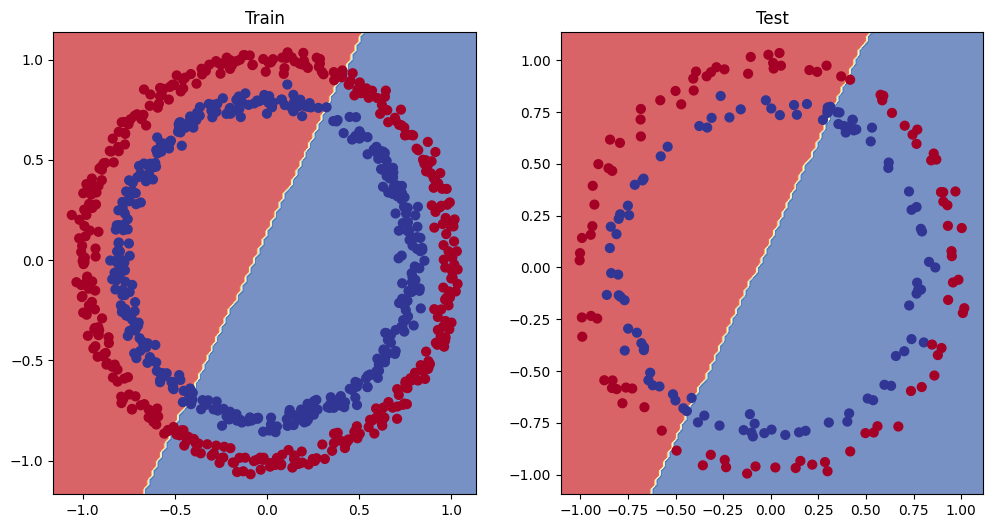

In [28]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_0, X=X_test, y=y_test)